In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
number_data_point = 5000

# A probabilistic generator for tao
tao = 10
phi = np.exp(-1/tao)

quantization = 255 # 8 bit image

intensity_mean = 80
intensity_std = 20

# A probabilistic generator for the innovation term.
innovation_mean = intensity_mean*(1-phi) # this is the c term in the wikipedia construction
innovation_std = intensity_std*np.sqrt(1-phi**2) # this is the standard deviation of the innovation 
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

intensity_variance = intensity_std**2 # this is the expectation value of all intensity signals
X = np.random.normal(loc = intensity_mean, scale = intensity_std, size = number_data_point) #initialize data matrix

print('The mean intensity is {}'.format(intensity_mean))
print('The variance of intensity is {}'.format(intensity_variance))
print('variance normalized by mean-squared is {}. This will be the magnitude of the first pt of the Autocorrelation function'.format(intensity_variance/intensity_mean**2))

The mean intensity is 80
The variance of intensity is 400
variance normalized by mean-squared is 0.0625. This will be the magnitude of the first pt of the Autocorrelation function


In [4]:
print('The mean of innovation is {}'.format(innovation_mean))
print('The std of innovation is {}'.format(innovation_std))

The mean of innovation is 7.613006557123239
The std of innovation is 8.515145258232963


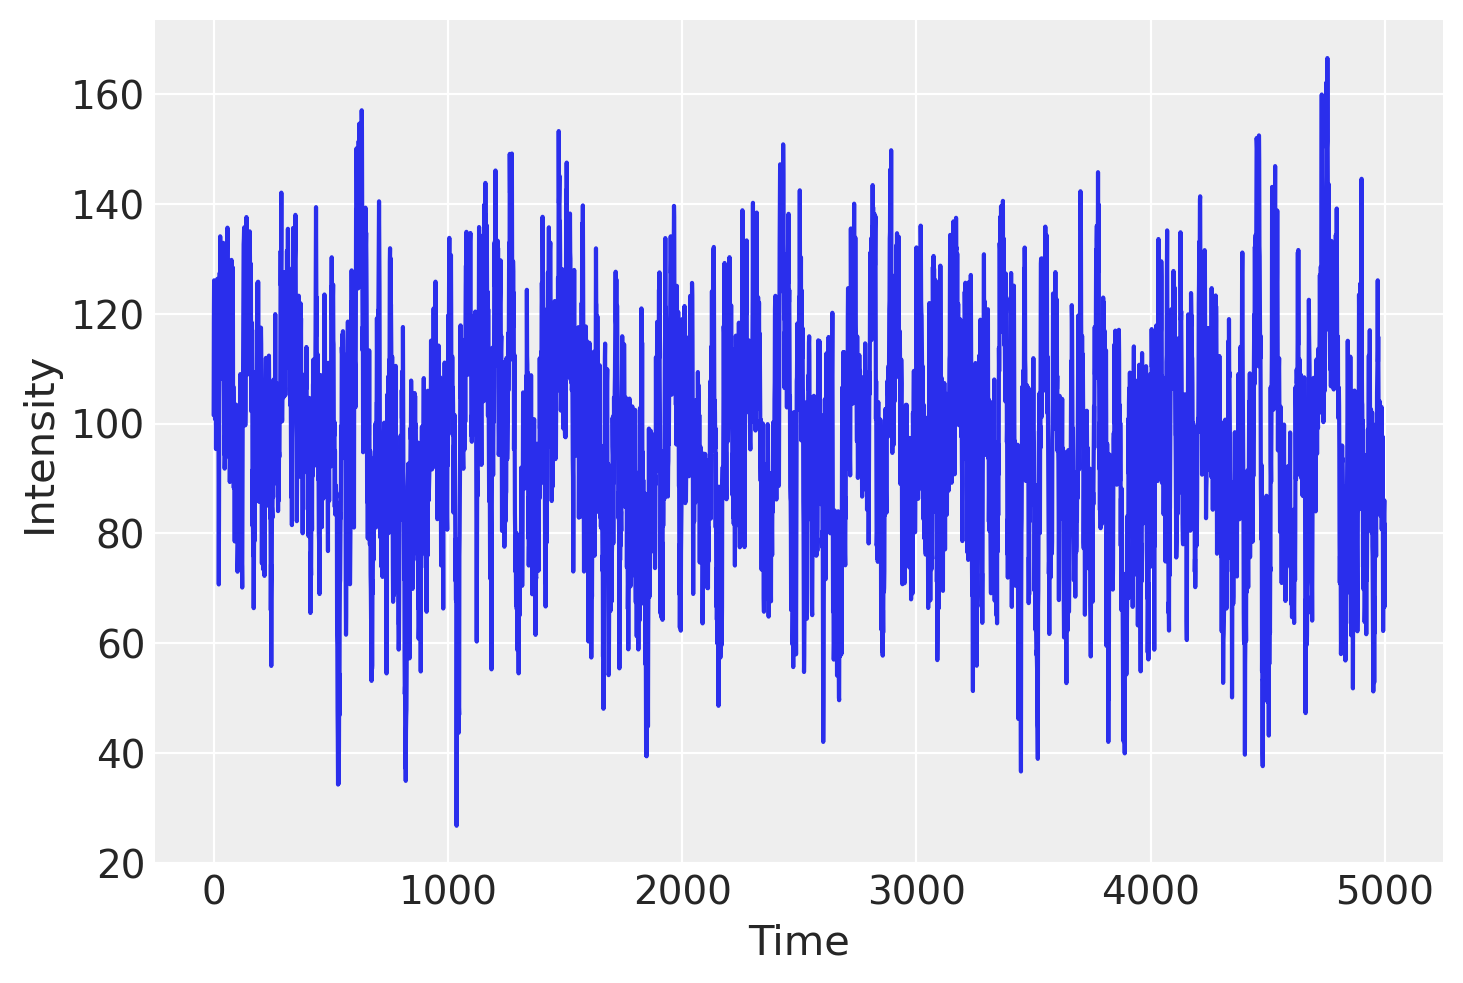

In [5]:
#Generate model data
for i in np.arange(number_data_point-1):
    X[i+1]= innovation_mean + phi*X[i] + innovation[i] # Data not normalized

#Add camera noise
camera_noise_mean = 20
camera_noise_std = 5
camera_noise = np.random.normal(loc = camera_noise_mean, scale = camera_noise_std, size = number_data_point)

X_simulated_data = X+camera_noise

#Plot model data
#plt.plot(np.arange(number_data_point),X_normalized,'o')
plt.plot(np.arange(number_data_point),X_simulated_data,'-')
plt.xlabel('Time')
plt.ylabel('Intensity')
#plt.ylim([0,quantization])
plt.show()

In [6]:
# #Correlation between neighboring pts
# averaged_pts = 400 
# pth_neighbor = np.array([1,round(0.2*tao),round(tao),round(5*tao)])
# number_correlation_illustration = len(pth_neighbor)
# for i in np.arange(number_correlation_illustration):
#     plt.subplot(2,2,i+1)
#     #plt.plot(X_normalized[0:averaged_pts],X_normalized[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
#     plt.plot(X_simulated_data[0:averaged_pts],X_simulated_data[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
#     plt.xlabel('Intensity at t')
#     #plt.ylabel('$X_{t+1}$'.format(pth_neighbor))
#     plt.ylabel('Intensity at t + {}'.format(pth_neighbor[i]))
# plt.show()

Autocorrelation:

$\frac{<I(t)I(t+\tau)>}{<I(t)><I(t+\tau)>} - 1$

In [7]:
# # Autocorrelation function
# longest_lag_time = 100
# lag_time = np.arange(longest_lag_time)
# averaged_pts = 4000 #Need averaged_pts+lognes_lag_time < number_data_point
# Intensity_matrix = np.zeros([longest_lag_time,averaged_pts])
# Correlation_matrix = np.zeros([longest_lag_time,averaged_pts])

# for i in lag_time:
#     #Intensity_matrix[i] = X_normalized[i:i+averaged_pts] 
#     Intensity_matrix[i] = X_simulated_data[i:i+averaged_pts] 
#     Correlation_matrix[i] = Intensity_matrix[0]*Intensity_matrix[i]

# Autocorrelation = np.average(Correlation_matrix, axis = 1) / (np.average(Intensity_matrix[0])*np.average(Intensity_matrix, axis = 1)) - 1

# plt.subplot(121)
# plt.plot(lag_time,Autocorrelation,'o')   
# plt.xlabel('Lag time')
# plt.ylabel('Autocorrelation function')
# plt.subplot(122)
# plt.plot(lag_time,np.log(Autocorrelation),'o')   
# plt.xlabel('Lag time')
# plt.ylabel('Log of autocorrelation function')
# plt.show()

In [8]:
pm.AR1?

Init signature: pm.AR1(k, tau_e, *args, **kwargs)
Docstring:     
Autoregressive process with 1 lag.

Parameters
----------
k: tensor
   effect of lagged value on current value
tau_e: tensor
   precision for innovations
File:           ~/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/pymc3/distributions/timeseries.py
Type:           type
Subclasses:     


In [59]:
(1+phi**2)*camera_noise_std**2

45.46826882694954

In [27]:
innovation_std**2

72.5076987688073

In [54]:
# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'phi'is ln(-1/tau) used in our generative model
    decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
    stationarity = np.exp(-1/decay_time)
    # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    precision_AR1 = pm.Uniform("precision", lower = 0 , upper = 1) 
    # process mean
    center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data
    # camera noise mean
    noise_mean = pm.Uniform("noise_mean", lower = 0, upper = quantization)
    # camera noise std
    noise_std = pm.Uniform("noise_std", lower = 0, upper = quantization)
    
    precision_overall = 1/(1/precision_AR1 + (1+phi**2)*noise_std**2)
    
    likelihood = pm.AR1("y", k=stationarity, tau_e=precision_overall, observed = X_simulated_data - center - noise_mean)

In [55]:
estimate = pm.find_MAP(model = ar1_model)

In [56]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/4c/vpfj2cz13377t1cw_xxjyj4w0000gn/T/ipykernel_18638/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 31400
Interrupted at 31,399 [15%]: Average Loss = 21,238
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_std, noise_mean, center, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 52 seconds.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6392237478889645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6661600294292085, but should be close to 0.8. Try to increase the number of tuning steps.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.404331389079323, but should be close to 0.8. Try to increase the number of tuning steps.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5627491429713161, but should be close to

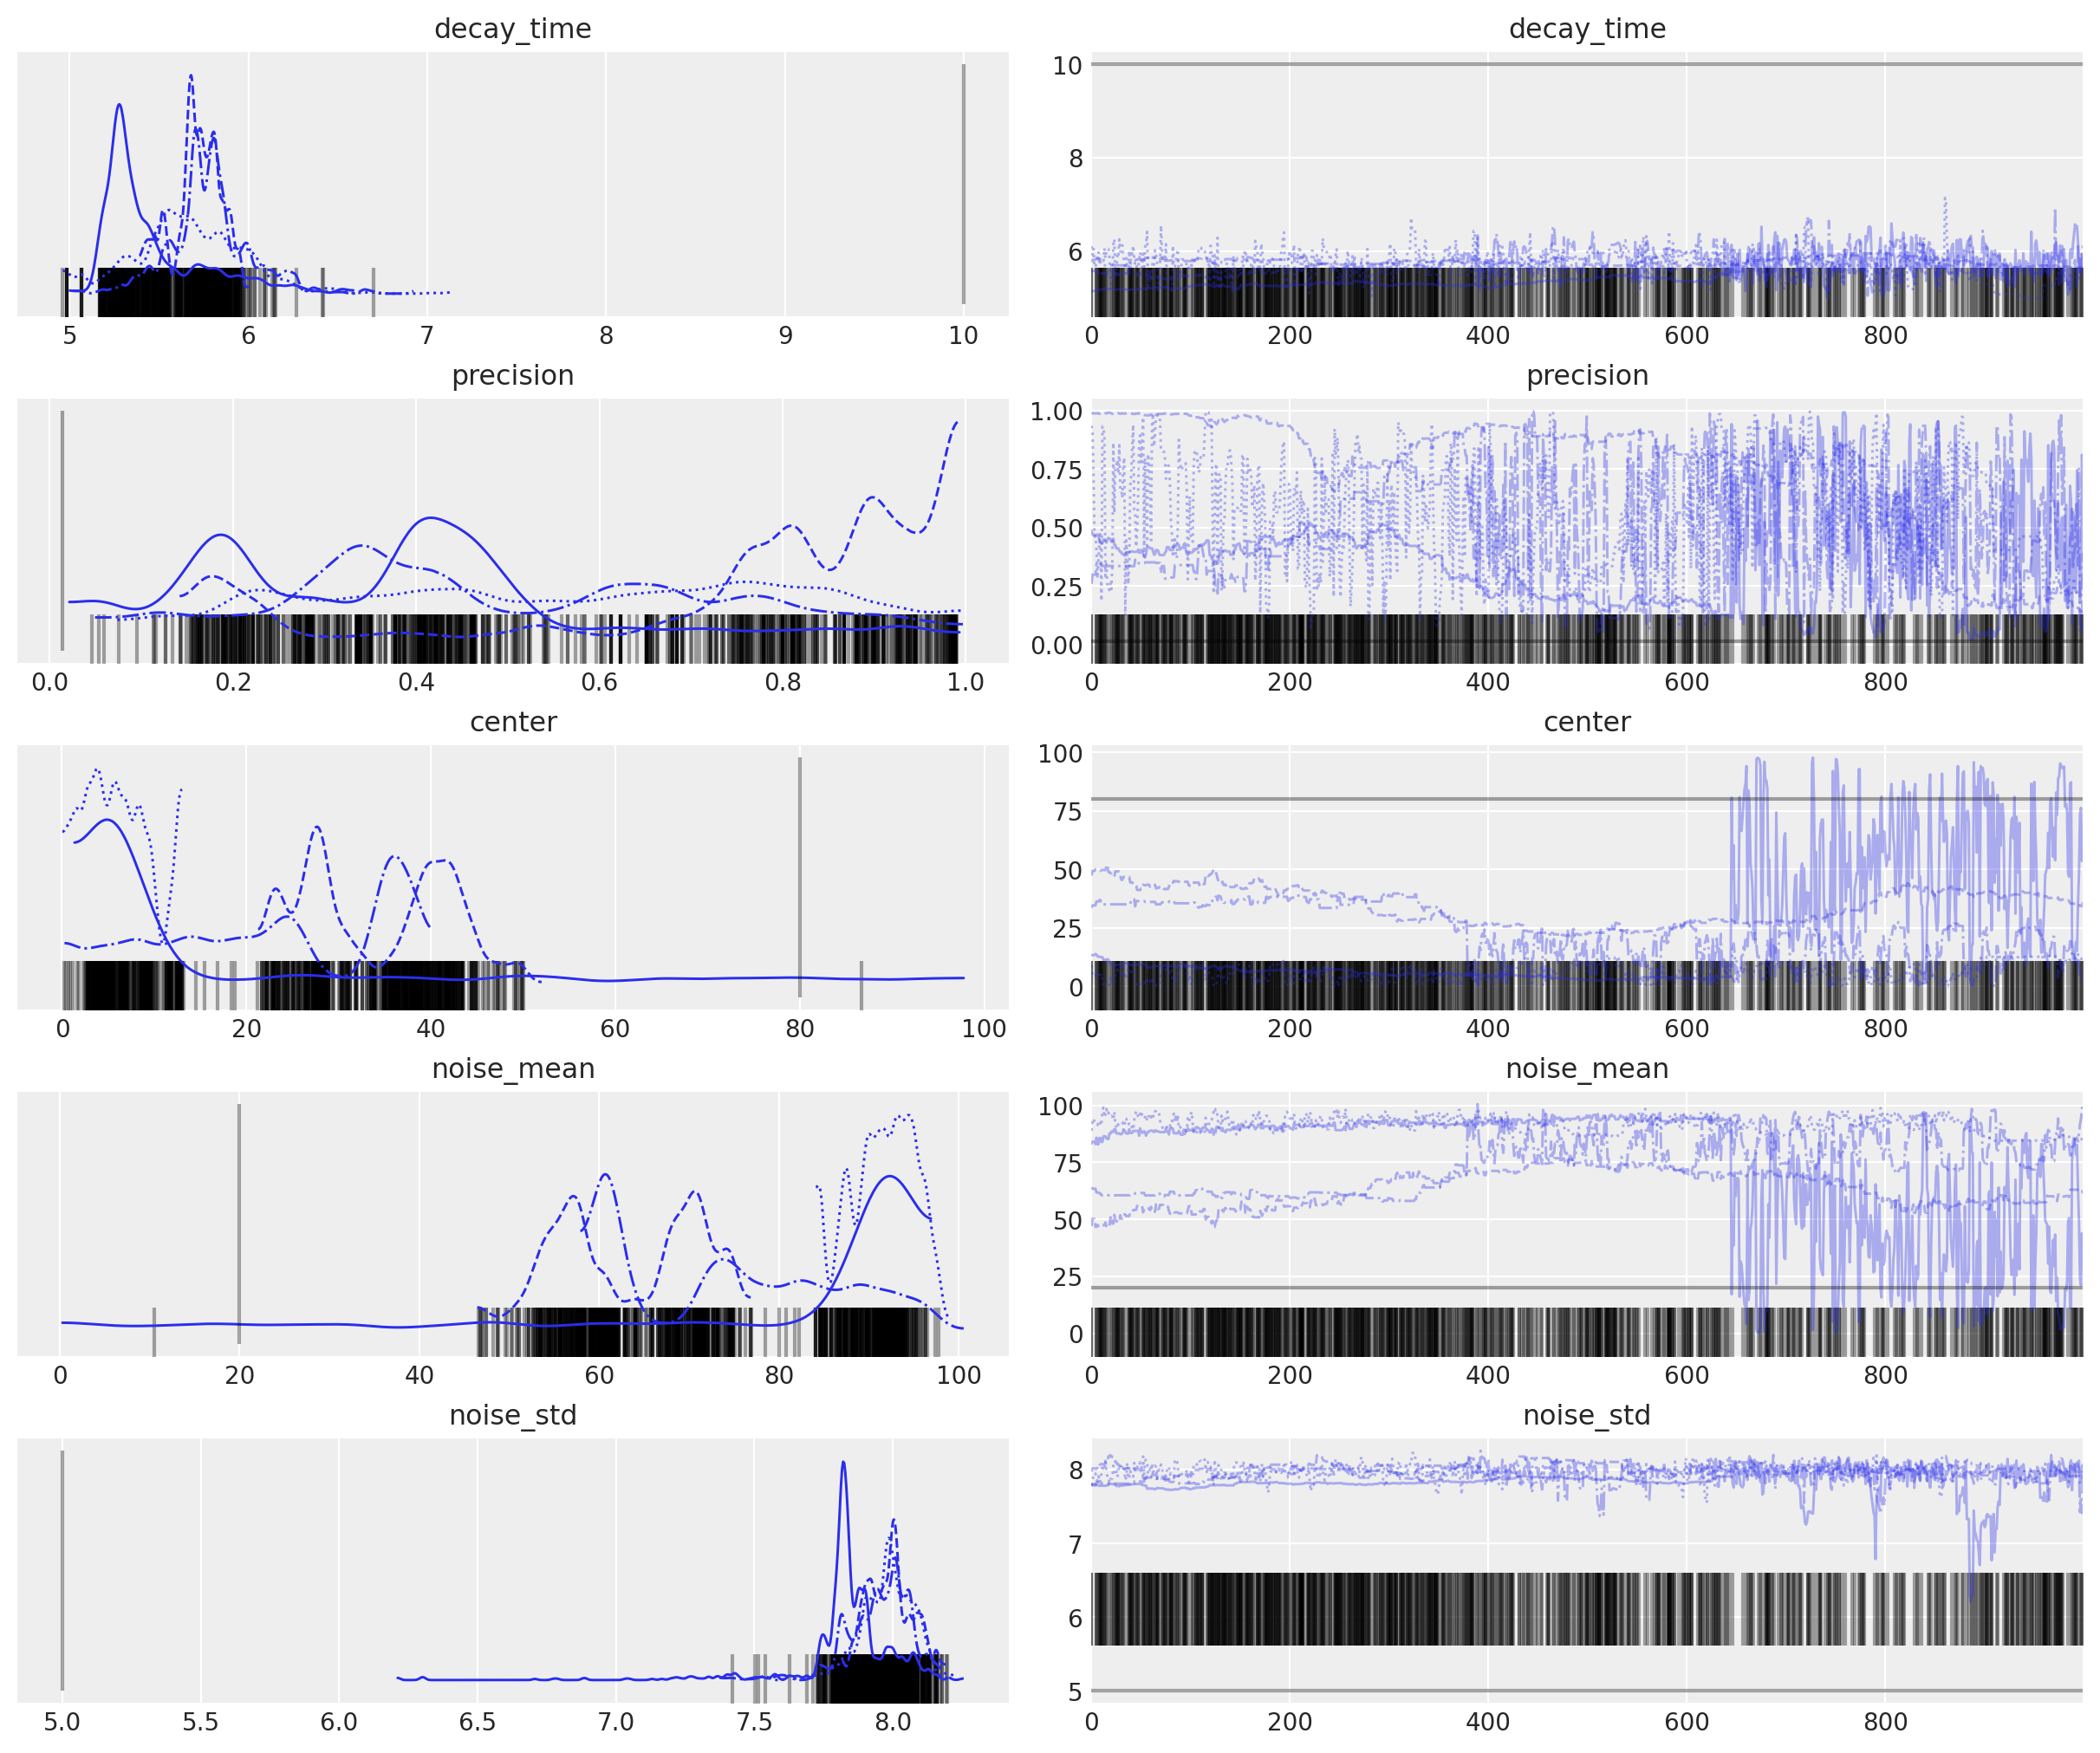

In [57]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time", {}, tao),
        ("precision", {}, 1/(innovation_std**2)),
        ("center", {}, intensity_mean),
        ("noise_mean", {}, camera_noise_mean),
        ("noise_std", {}, camera_noise_std),
    ],
);